# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# Setup Seaborn
sns.set_style("whitegrid")
#sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [3]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [5]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
df = pd.merge(df_offers, df_transactions)
df_pivot = pd.pivot_table(df, values='n', index=['customer_name'], columns=['offer_id'])
df_pivot = df_pivot.fillna(0).reset_index()
df_pivot.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

> I think lower values of SS represent better clusterings since it indicates that each data point is tightly around the centroid of the cluster assigned. 

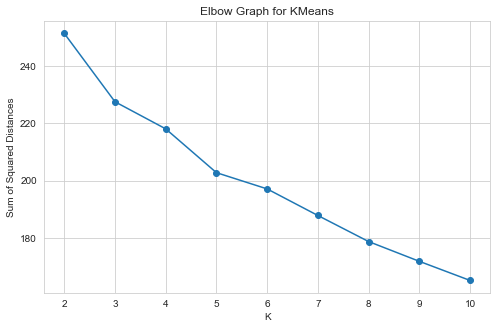

In [7]:
# Create a numpy matrix with only the columns representing the offers (i.e. the 0/1 columns)
x_cols = df_pivot.iloc[:, 1:]

ss = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k)
    model.fit(x_cols)
    ss.append(model.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(K, ss, '-o')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Graph for KMeans');

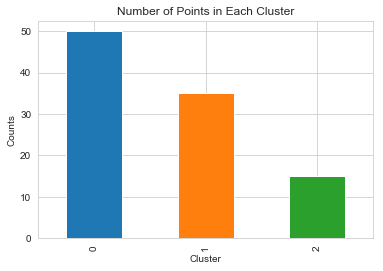

In [8]:
kmeans = KMeans(n_clusters=3)
kmeans_pred = kmeans.fit_predict(x_cols)
pd.Series(kmeans_pred).value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('Number of Points in Each Cluster');

> It's not obvious to pick the best K from the elbow graph above. Since this graph does not have a steep decline for the small Ks and it's unclear to find the point where SS starts to decline more slowly. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [9]:
# Transform our multi-dimensional dataset into a 2 dimensional dataset so it's much easier to plot. 
pca = PCA(n_components=2)
X = pca.fit_transform(x_cols)

For n_clusters = 2 The average silhouette_score is : 0.4122065490579868
For n_clusters = 3 The average silhouette_score is : 0.5303468047843276
For n_clusters = 4 The average silhouette_score is : 0.4488012937986855
For n_clusters = 5 The average silhouette_score is : 0.46899611744737696
For n_clusters = 6 The average silhouette_score is : 0.4764899004116145
For n_clusters = 7 The average silhouette_score is : 0.47293508309031757
For n_clusters = 8 The average silhouette_score is : 0.5138557320630397
For n_clusters = 9 The average silhouette_score is : 0.4908949849291526
For n_clusters = 10 The average silhouette_score is : 0.5138800346898216


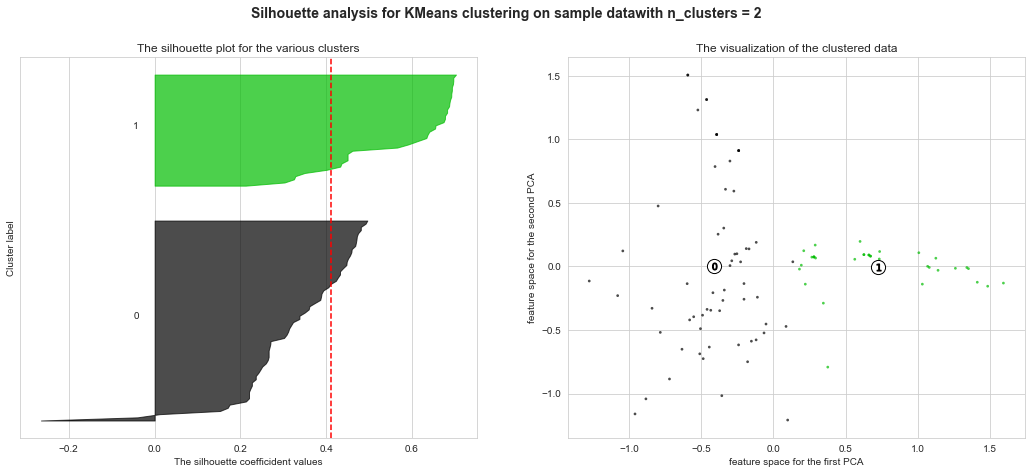

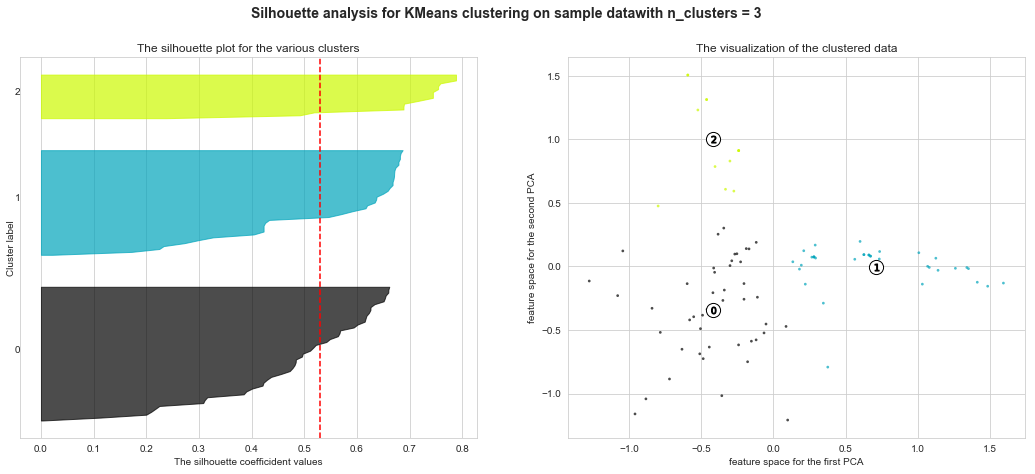

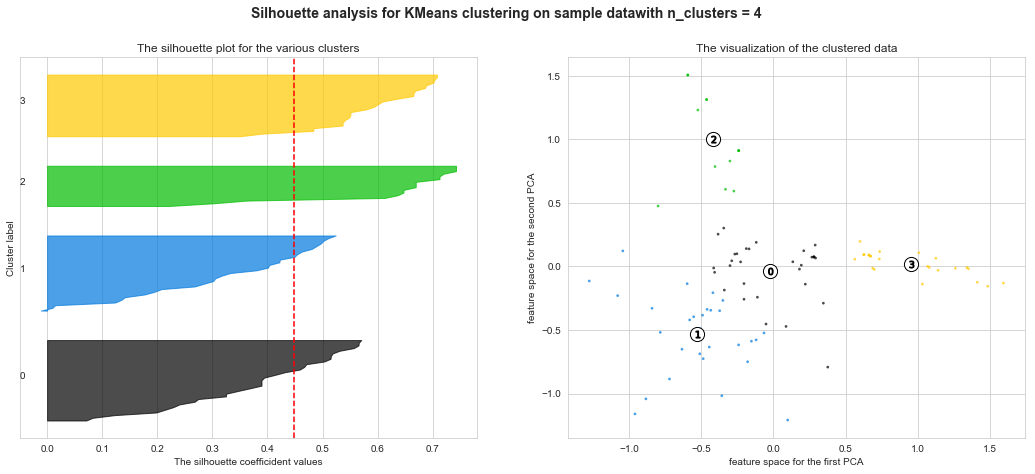

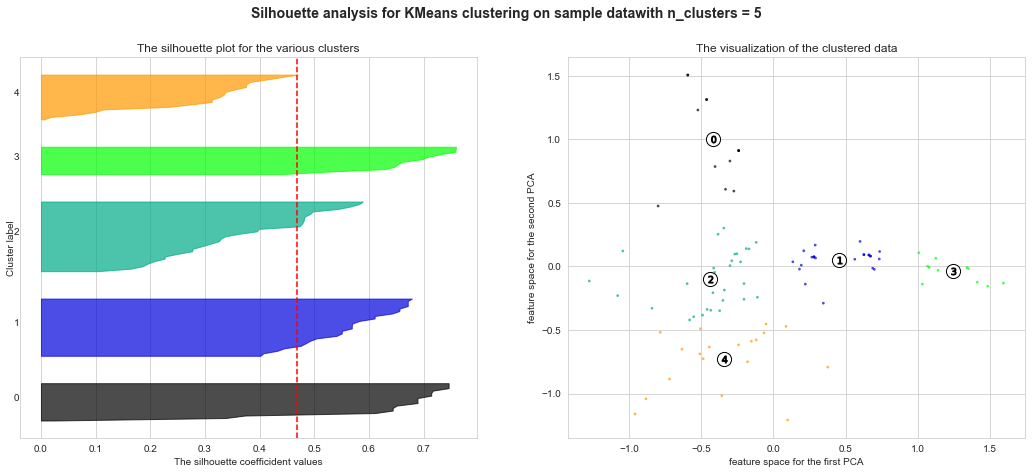

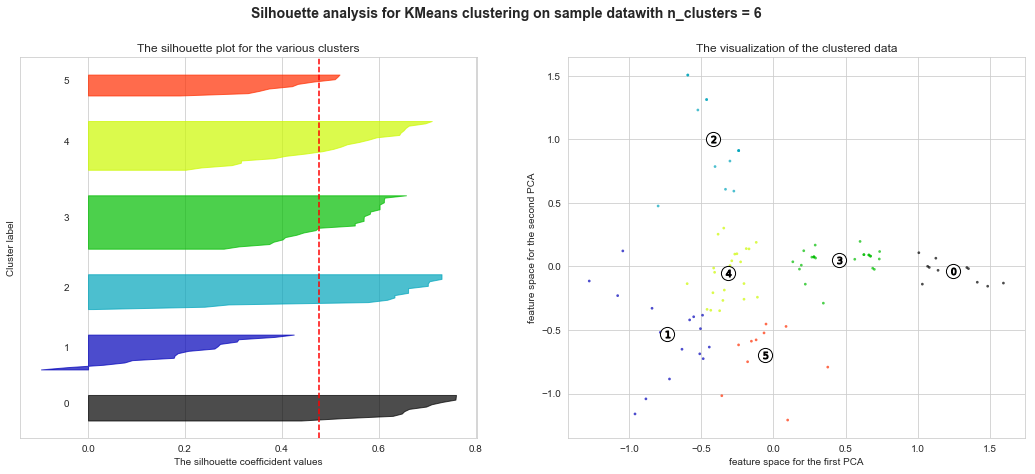

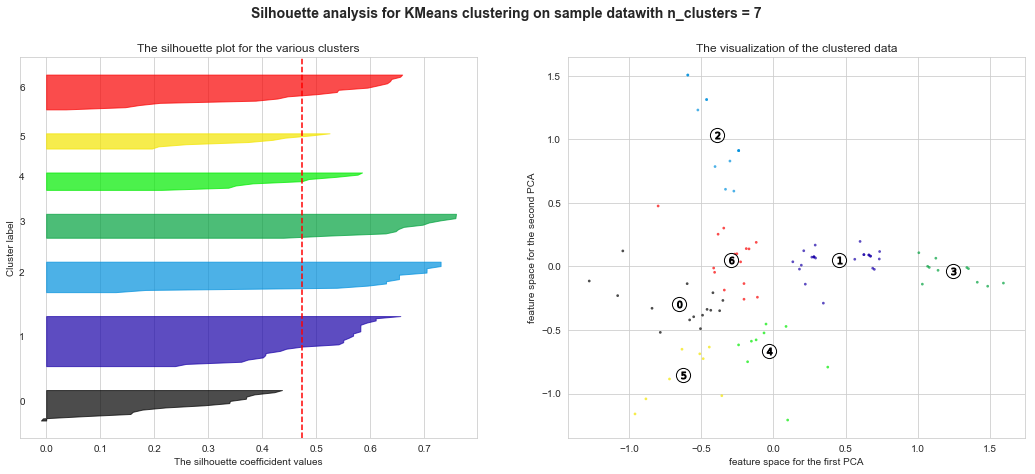

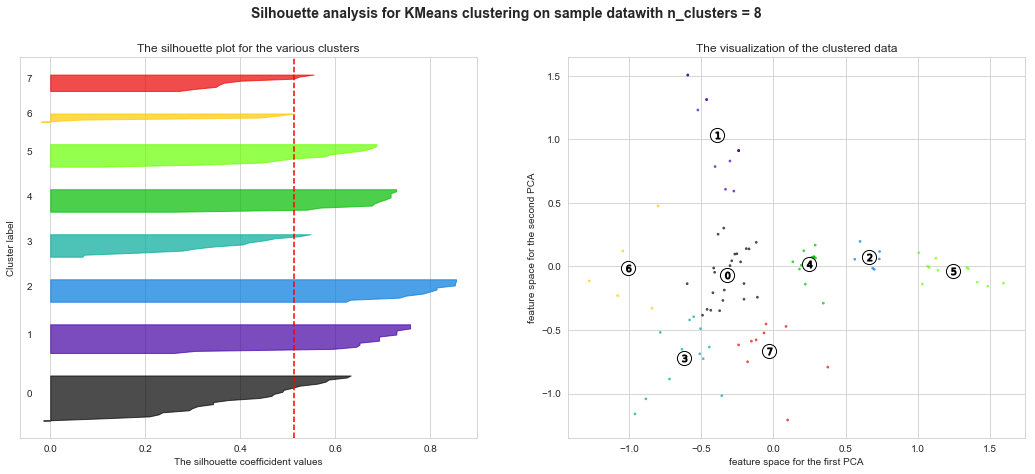

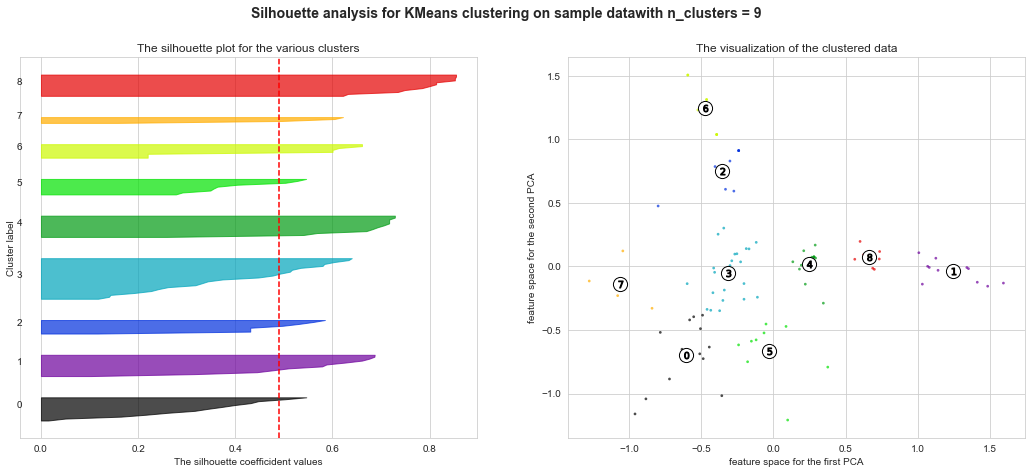

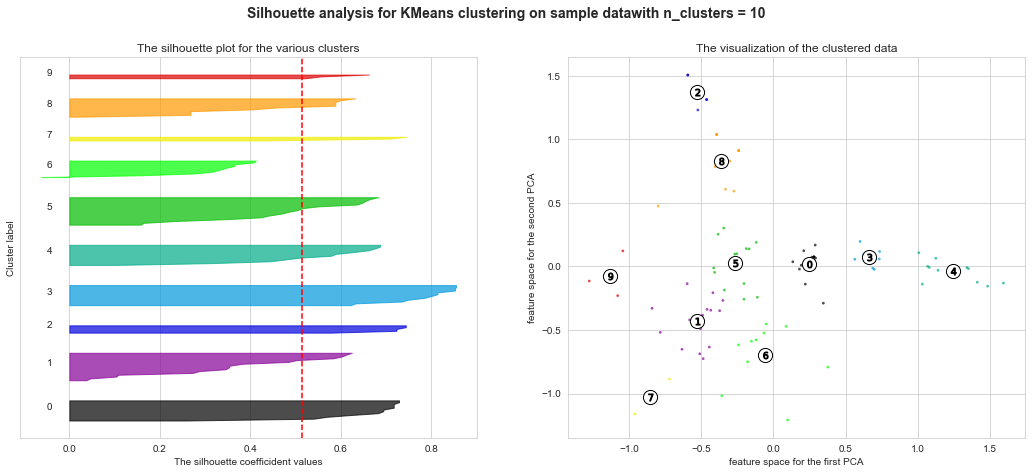

In [10]:
# Compute the average silhouette score for each K and plot it using PCA components.
for k in K:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    clusterer = KMeans(n_clusters=k)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For n_clusters =', k, 'The average silhouette_score is :', silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
    
    ax1.set_title('The silhouette plot for the various clusters')
    ax1.set_xlabel('The silhouette coefficident values')
    ax1.set_ylabel('Cluster label')
    
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax1.set_yticks([])
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%a$' % i, alpha=1, s=50, edgecolor='k')
        
    ax2.set_title('The visualization of the clustered data')
    ax2.set_xlabel('feature space for the first PCA')
    ax2.set_ylabel('feature space for the second PCA')
    
    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data'
                'with n_clusters = %d' % k), fontsize=14, fontweight='bold')


> From the calculation of average silhouette score and the plots, we should pick n_clusters=3 which gives us the highest average score and the scores for each individual values are greater than 0. The n_clusters value of 2, 6, 8, 9 and 10 have individual points with negative scores. The n_clusters value of 5, 7, 8, 9, 10 have clusters with below average scores. 

For n_clusters = 2 The average silhouette_score is : 0.09007566678796264
For n_clusters = 3 The average silhouette_score is : 0.11240643031242324
For n_clusters = 4 The average silhouette_score is : 0.13045103923500836
For n_clusters = 5 The average silhouette_score is : 0.13391496319668214
For n_clusters = 6 The average silhouette_score is : 0.1143633704734922
For n_clusters = 7 The average silhouette_score is : 0.12466193591484073
For n_clusters = 8 The average silhouette_score is : 0.12033232497806944
For n_clusters = 9 The average silhouette_score is : 0.11690375136816857
For n_clusters = 10 The average silhouette_score is : 0.1414076490274665


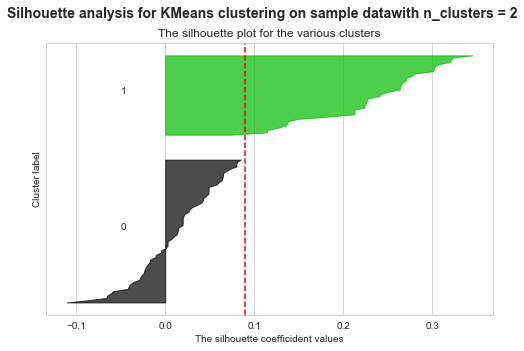

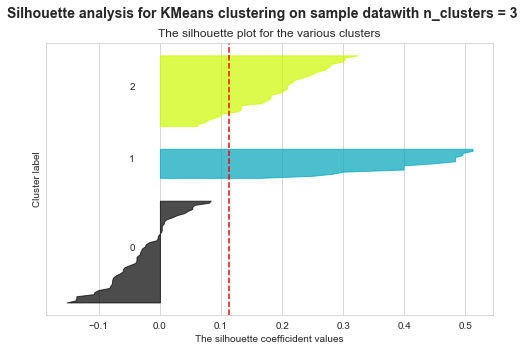

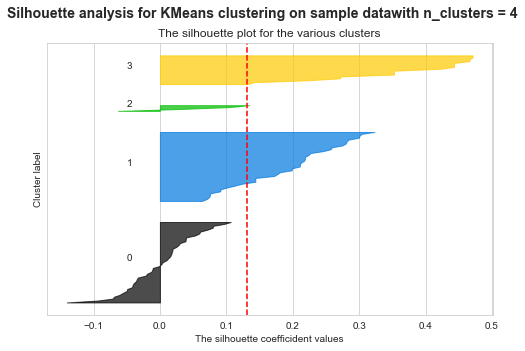

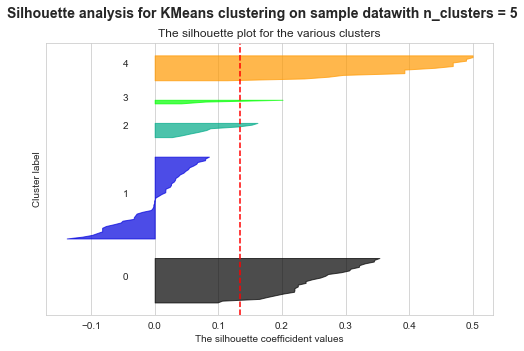

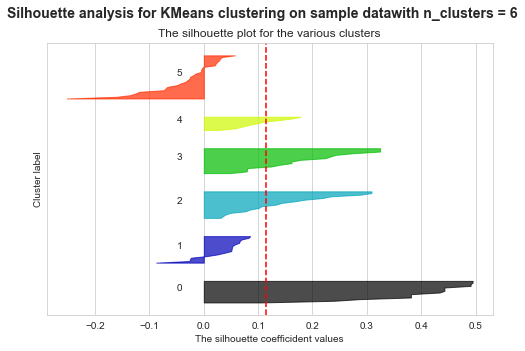

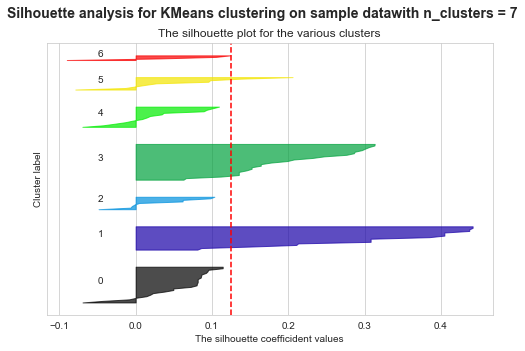

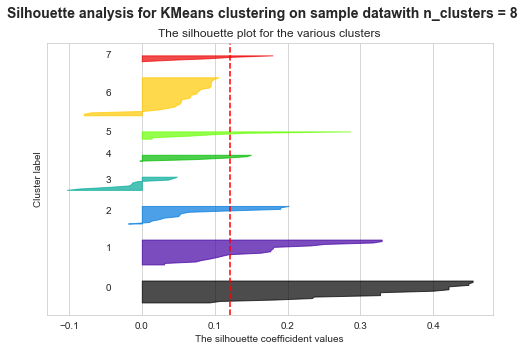

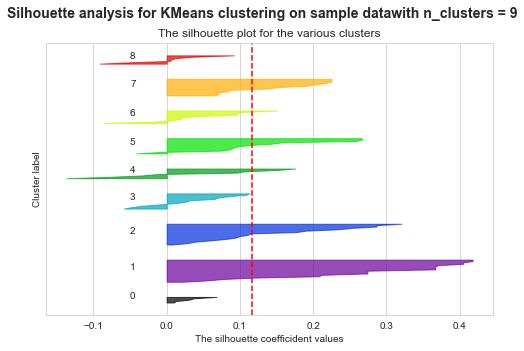

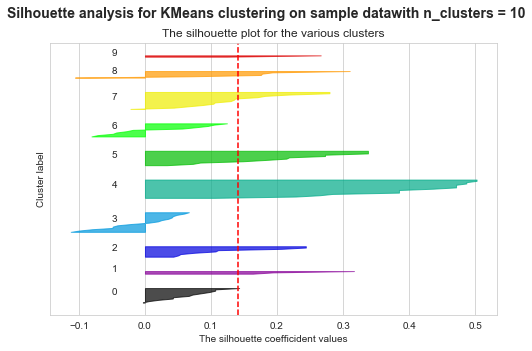

In [11]:
# Compute the average silhouette score for each K and plot it using orginal features instead of PCA.
for k in K:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    
    clusterer = KMeans(n_clusters=k, random_state=28)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print('For n_clusters =', k, 'The average silhouette_score is :', silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
    
    ax.set_title('The silhouette plot for the various clusters')
    ax.set_xlabel('The silhouette coefficident values')
    ax.set_ylabel('Cluster label')
    
    ax.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax.set_yticks([])
    
    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data'
                'with n_clusters = %d' % k), fontsize=14, fontweight='bold')

> Based on the silhouette anaysis above, the best value of K might be 5 which has the highest average silhouette score. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [12]:
# choosing k=3 based on elbow graph and silhoutte score with PCA components as features
df_cluster = pd.DataFrame({'customer_name': df_pivot.customer_name, 
                  'cluster_id': kmeans_pred, 
                  'x': X[:, 0],
                  'y': X[:, 1]})
df_cluster.head()

,customer_name,cluster_id,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


In [13]:
# choosing k=5 based on silhoutte score with original features 
clusterer = KMeans(n_clusters=5)
cluster_id_5 = clusterer.fit_predict(X)

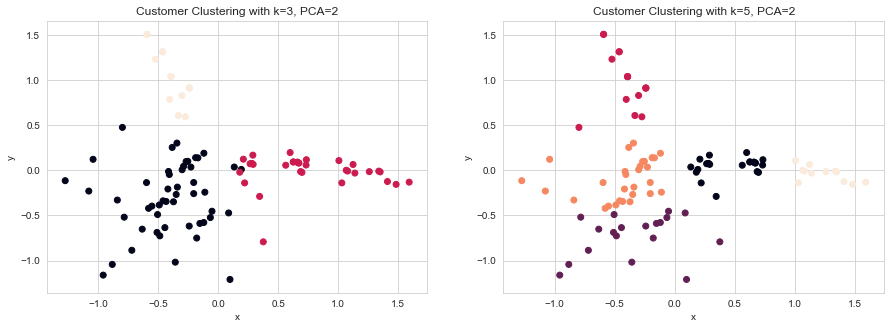

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(df_cluster.x, df_cluster.y, c=df_cluster.cluster_id)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Customer Clustering with k=3, PCA=2')

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=cluster_id_5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Customer Clustering with k=5, PCA=2');

> It seems that the best value for k is 3. When k=5, we can see that clusters are not well separated. 

In [15]:
df_new = df.merge(df_cluster[['customer_name', 'cluster_id']])
df_new.sort_values('cluster_id').head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_id
0,1,January,Malbec,72,56,France,False,Thomas,1,0
137,9,April,Chardonnay,144,57,Chile,False,Young,1,0
138,15,June,Cabernet Sauvignon,144,19,Italy,False,Young,1,0
139,22,August,Champagne,72,63,France,False,Young,1,0
140,31,December,Champagne,72,89,France,False,Young,1,0


In [16]:
df_new.groupby('cluster_id').varietal.value_counts()

cluster_id  varietal          
0           Champagne             76
            Cabernet Sauvignon    31
            Prosecco              22
            Malbec                16
            Chardonnay            15
            Merlot                13
            Pinot Noir             9
            Espumante              8
            Pinot Grigio           1
1           Espumante             32
            Prosecco              20
            Malbec                16
            Pinot Grigio          16
            Merlot                 6
            Champagne              5
            Cabernet Sauvignon     1
2           Pinot Noir            35
            Merlot                 1
            Prosecco               1
Name: varietal, dtype: int64

In [17]:
df_new.groupby('cluster_id').min_qty.value_counts()

cluster_id  min_qty
0           72         122
            144         44
            6           14
            12          11
1           6           84
            72           5
            12           4
            144          3
2           6           12
            144         11
            12           7
            72           7
Name: min_qty, dtype: int64

In [18]:
df_new.groupby('cluster_id').origin.value_counts()

cluster_id  origin      
0           France          89
            Chile           30
            Italy           12
            New Zealand     12
            California      11
            Oregon          11
            Australia       10
            Germany          8
            South Africa     8
1           France          34
            Australia       17
            South Africa    17
            Oregon          15
            Chile            7
            California       4
            Germany          1
            New Zealand      1
2           Australia       12
            Italy           12
            Germany          7
            France           5
            California       1
Name: origin, dtype: int64

> Clustering does correspond to wine variants. We can see that cluster 0 prefers Pinot Noir, cluster 1 prefers Espumante and Prosecco , while cluster 3 prefers Champagne and Cabernet Sauvignon. For min_qty, cluster 0 is quite spread, they are buying wine in low, medium and high quanties. cluster 1 is buying a lot of low quantity wine, while cluster 2 is buying a lot of high quantities wine. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

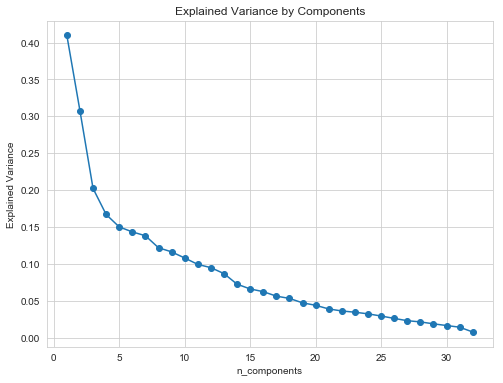

In [19]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)

y_pca = pca.explained_variance_
x_pca = np.arange(1, len(y_pca)+1)

plt.figure(figsize=(8, 6))
plt.plot(x_pca, y_pca,'-o')
plt.xlabel('n_components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components');

> The elbow point is at 3 components, where the curve starts to descent slowly. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [20]:
def cluster_models(model, **kwargs):
    '''Fit data with model and return silhouette coeffficient and labels for each samples'''
    cluster = model(**kwargs)
    cluster.fit(x_cols)
    labels = cluster.labels_
    score = silhouette_score(x_cols, labels)
    
    cluster_pca = model(**kwargs)
    cluster_pca.fit(X)
    labels_pca = cluster_pca.labels_
    score_pca = silhouette_score(X, labels_pca)
    
    plt.scatter(X[:, 0], X[:, 1], c=labels_pca, cmap='tab10')
    return score, labels, score_pca, labels_pca

### Affinity propagation

Number of Clusters = 14
Silhouette Coefficient for Affinity Propogation model = 0.12346523604478911


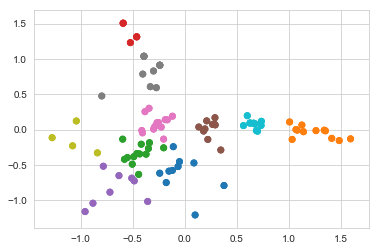

In [21]:
print('Number of Clusters = {}'.format(len(np.unique(cluster_models(AffinityPropagation)[1]))))
print('Silhouette Coefficient for Affinity Propogation model = {}'.format(cluster_models(AffinityPropagation)[0]))

### Spectral Clustering

Silhouette Coefficient for Spectral Clustering model = 0.09990591231024579


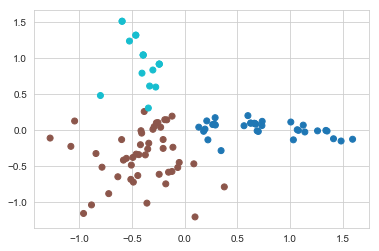

In [22]:
print('Silhouette Coefficient for Spectral Clustering model = {}'.format(
    cluster_models(SpectralClustering, n_clusters=3)[0]))

### Agglomerative Clustering

Silhouette Coefficient for Agglomerative Clustering model = 0.11625878863607858


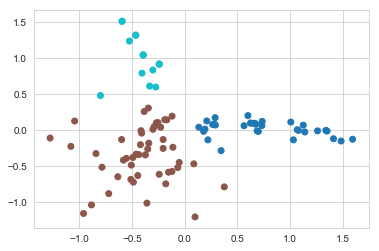

In [23]:
print('Silhouette Coefficient for Agglomerative Clustering model = {}'.format(
    cluster_models(AgglomerativeClustering, n_clusters=3)[0]))

### DBSCAN

In [24]:
cluster_db = DBSCAN(eps=1.5)
cluster_db.fit(x_cols)
labels = cluster_db.labels_
print('Number of Clusters = {}'.format(len(np.unique(labels))))
print('Silhouette Coefficient forDBSCAN model = {}'.format(silhouette_score(x_cols, labels)))

Number of Clusters = 2
Silhouette Coefficient forDBSCAN model = 0.11989886685810866


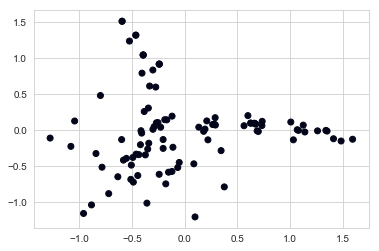

In [25]:
cluster_db_pca = DBSCAN(eps=1.5).fit(X)
labels_pca = cluster_db_pca.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels_pca);

> It seems that Affinity propagation is overfitting the data and DBSCAN is underfitting. Spectral clustering and agglomerative clustering is doing well. Comparing these methods by graph and silhouette coefficient, agglomerative clustering model is better. 